In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from SALib.analyze import sobol

# to remove spines at the top and right
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [12]:
results = pd.read_csv('../data/concat_data.csv', index_col=0)
results['diff'] = results['newts_buffer'] - results['newts_corridor']

param_values = pd.read_csv('../data/parameter_new.csv', index_col=0)

problem = {
    'num_vars': 7,
    'names': [
        #'number-of-startind', # 15
        'capacity',  # 20
        'mean-juvenile-mortality-prob', # 0.5
        'mean-adult-mortality-prob', #0.2
        #'cropland-movement-cost', #5
        #'woodland-movement-cost', #1
        #'angle-for-viewing-ponds-and-woodland', #140
        'mortality-decrease-with-buffer', #0.1
        'distance-for-viewing-ponds-and-woodland', #2
        'movement-energy', #700
        'mean-number-of-female-offspring' #5
    ],
    'bounds': [
        #[5, 80],
        [10, 40],
        [0.3, 0.7],
        [0.1, 0.3],
        #[5, 7],
        #[1, 4],
        #[70, 180],
        [0.001, 0.2],
        [0.5, 3],
        [200, 1000],
        [4, 6]
    ]
}

results

,newts_buffer,newts_corridor,ponds_buffer,ponds_corridor,mean_newts_buffer,mean_ponds_buffer,mean_newts_corridor,mean_ponds_corridor,diff
0,36.0,0.0,6.0,0.0,31.363636,6.000000,5.818182,1.181818,36.0
1,93.0,26.0,7.0,5.0,102.727273,7.000000,33.363636,4.272727,67.0
2,6.0,0.0,2.0,0.0,13.000000,2.818182,3.636364,0.636364,6.0
3,12.0,0.0,3.0,0.0,15.363636,3.363636,3.636364,0.636364,12.0
4,33.0,3.0,6.0,2.0,35.909091,6.909091,14.818182,3.181818,30.0
...,...,...,...,...,...,...,...,...,...
251,0.0,0.0,0.0,0.0,0.000000,0.000000,3.636364,0.636364,0.0
252,0.0,0.0,0.0,0.0,0.000000,0.000000,3.636364,0.636364,0.0
253,0.0,0.0,0.0,0.0,0.000000,0.000000,3.636364,0.636364,0.0
254,11.0,0.0,3.0,0.0,11.272727,2.818182,3.636364,0.636364,11.0


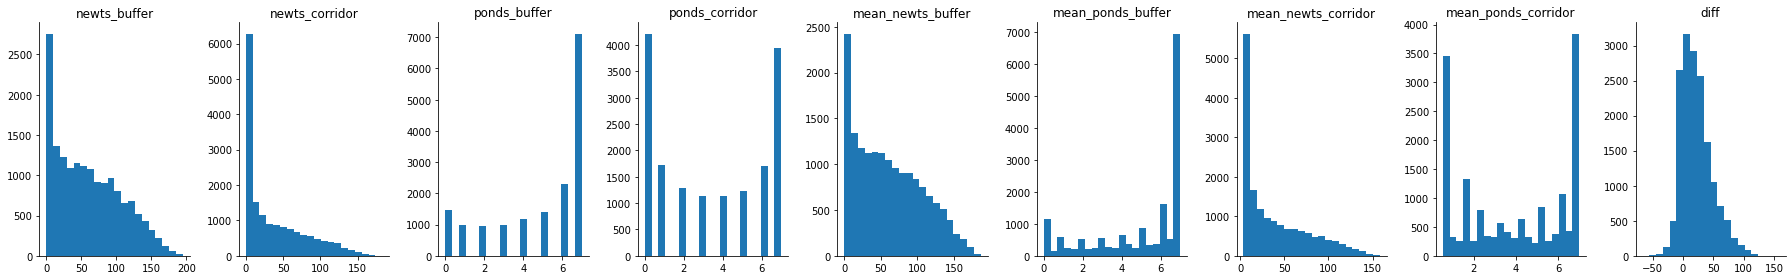

In [13]:
plt.figure(figsize=(25,4))
for i, output_name in enumerate(results.columns):
    plt.subplot(1, len(results.columns), i+1)
    plt.hist(results[output_name], 20)
    plt.title(output_name)

#plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.savefig('../results/output_hist.svg')

In [14]:
from SALib.analyze import hdmr

y = results['newts_buffer'].values
Si_buffer = hdmr.analyze(problem, param_values.values, y, print_to_console=False);

y = results['newts_corridor'].values
Si_corridor = hdmr.analyze(problem, param_values.values, y, print_to_console=False);

y = results['diff'].values
Si_diff = hdmr.analyze(problem, param_values.values, y, print_to_console=False);

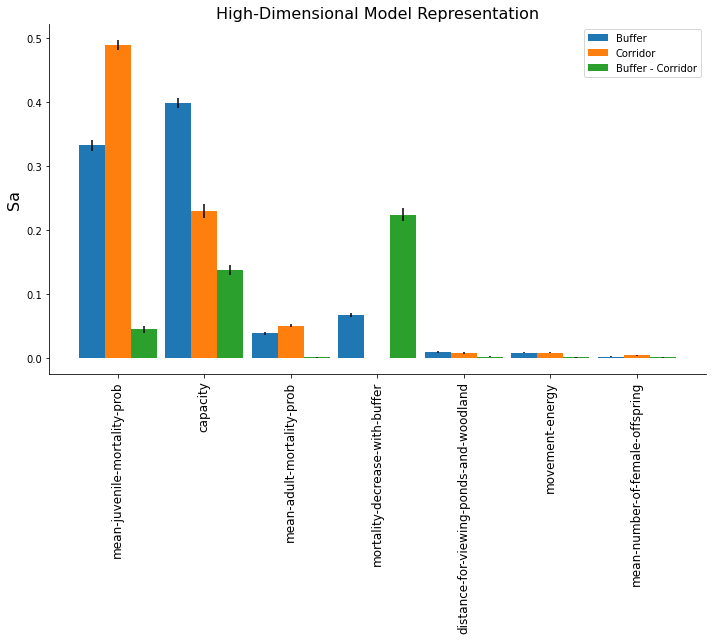

In [15]:
temp = np.array([Si_buffer['Sa'][0:7],
                 Si_corridor['Sa'][0:7]]).T

sorted_index = np.argsort(np.mean(temp, axis=1))[::-1]

order_no = 'Sa'
conf = f'{order_no}_conf'

plt.figure(figsize=(10,9))
plt.bar(np.arange(1,8)-0.3, Si_buffer[order_no][sorted_index][0:7], yerr=Si_buffer[conf][sorted_index][0:7], width=0.3, label='Buffer')
plt.bar(np.arange(1,8), Si_corridor[order_no][sorted_index][0:7], yerr=Si_corridor[conf][sorted_index][0:7], width=0.3, label='Corridor')
plt.bar(np.arange(1,8)+0.3, Si_diff[order_no][sorted_index][0:7], yerr=Si_diff[conf][sorted_index][0:7], width=0.3, label='Buffer - Corridor')
plt.xticks(np.arange(1,8), np.array(Si_buffer['Term'])[sorted_index][0:7], rotation=90, size=12)
plt.title('High-Dimensional Model Representation', size=16)
plt.ylabel(order_no, size=16)
plt.legend()
plt.tight_layout()
plt.savefig('../results/hdmr.svg');

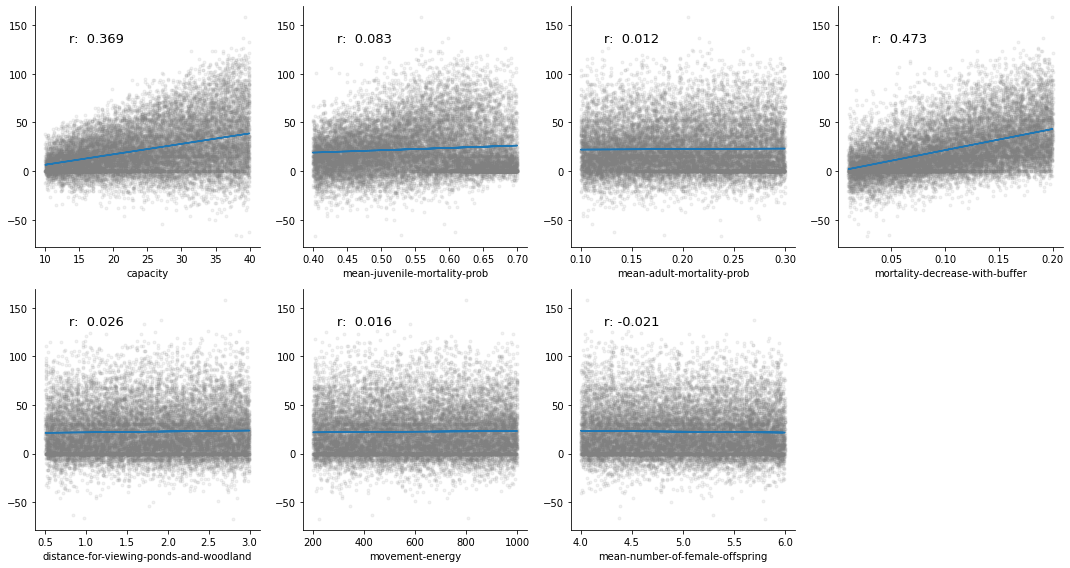

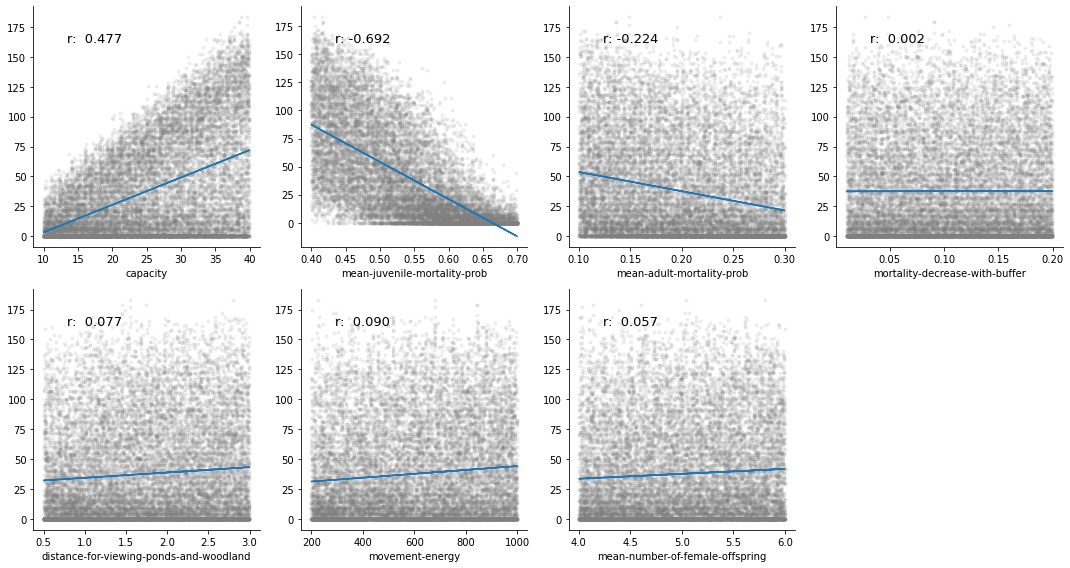

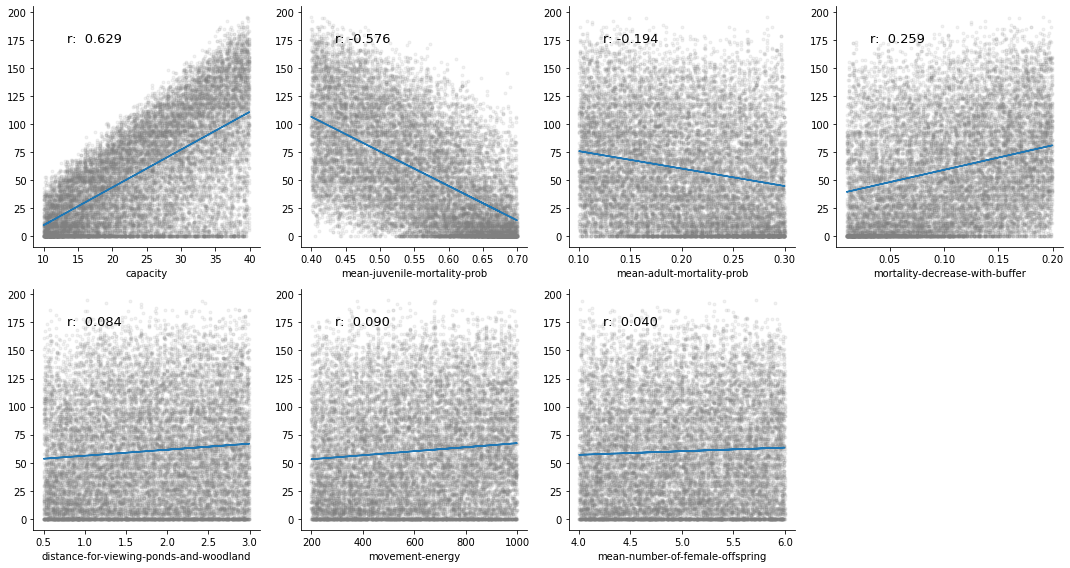

In [16]:
for scenario in ['diff', 'newts_corridor', 'newts_buffer']:
    
    plt.figure(figsize=(15,8))

    y = results[f'{scenario}']
    for i in range(7):
        plt.subplot(2,4,i+1)
        plt.xlabel(problem['names'][i])

        x = param_values.iloc[:,i]
        plt.plot(x,y, '.', alpha=0.1, color='gray')

        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        plt.plot(x, poly1d_fn(x), '-')

        pearson = scipy.stats.pearsonr(x, y)
        plt.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction',fontsize=13)
        #print(pearson[1])

    plt.tight_layout()
    plt.savefig(f'../results/corr_{scenario}.png')

In [ ]:
y = results['newts_buffer'].values
Si_buffer = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)

pd.DataFrame(Si_buffer['S2']) - pd.DataFrame(Si_buffer['S2_conf'])

In [ ]:
index_name, conf_name = 'S1', 'S1_conf' #'ST', 'ST_conf'

y = results['newts_buffer'].values
Si_buffer = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
buffer_df = pd.DataFrame({k:Si_buffer[k] for k in [index_name,conf_name]},index=problem['names']) 

y = results['newts_corridor'].values
Si_corridor = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
corridor_df = pd.DataFrame({k:Si_corridor[k] for k in [index_name,conf_name]},index=problem['names']) 

y = results['diff'].values
Si_diff = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
diff_df = pd.DataFrame({k:Si_diff[k] for k in [index_name,conf_name]},index=problem['names']) 

In [ ]:

sorting_index = np.array([1,0,2,3,4,5,6])
labels = ['mean-juvenile-\n mortality-prob', 
          'capacity',
         'mean-adult-\n mortality-prob',
         'mortality-decrease-\n with-buffer',
         'distance-for-viewing-\n ponds-and-woodland',
         'movement-energy',
         'mean-number-of-\n female-offspring']

plt.figure(figsize=(10,9))

plt.bar(np.arange(1,8)-0.3, buffer_df[index_name][sorting_index], 
        yerr=buffer_df[conf_name][sorting_index], 
        width=0.3, color='#9AC7BF', label='Buffer')

plt.bar(np.arange(1,8), corridor_df[index_name][sorting_index], 
        yerr=corridor_df[conf_name][sorting_index], 
        width=0.3, color='#F19C99', label='Corridor')

plt.bar(np.arange(1,8)+0.3, diff_df[index_name][sorting_index], 
        yerr=diff_df[conf_name][sorting_index], 
        width=0.3, color='#666666', label='Buffer - Corridor')


plt.xticks(np.arange(1,8), labels, rotation=90, size=16)
plt.yticks(size=16)

#plt.title('Sobol index', size=16)
plt.ylabel(index_name, size=18)
plt.legend(prop={"size":16}, frameon=False)
plt.tight_layout()


plt.savefig('../results/sobol.svg');

In [ ]:
pd.DataFrame(Si_buffer['S2'], index=problem['names'], columns=problem['names']) - pd.DataFrame(Si_buffer['S2_conf'], index=problem['names'], columns=problem['names'])

